In [59]:
!git clone https://github.com/abecode/teaching_reviews.git

fatal: destination path 'teaching_reviews' already exists and is not an empty directory.


In [60]:
!cp teaching_reviews/data_prodigy/prodigy.sentence-level.20240605.db prodigy.db

In [61]:
import sqlite3

In [62]:
con = sqlite3.connect('prodigy.db')

In [63]:
abe_annotations = con.execute("""select dataset.id, dataset.name, dataset.created, dataset.meta, dataset.session,
                                        example.id, example.input_hash, example.task_hash, example.content
                                 from dataset, example, link
                                 where dataset.id = link.dataset_id
                                   and link.example_id = example.id
                                   and dataset.name = 'teaching_reviews_sentences-abe';""").fetchall()

In [64]:
len(abe_annotations)

725

In [65]:
mengyuan_annotations = con.execute("""select dataset.id, dataset.name, dataset.created, dataset.meta, dataset.session,
                                        example.id, example.input_hash, example.task_hash, example.content
                                      from dataset, example, link
                                      where dataset.id = link.dataset_id
                                        and link.example_id = example.id
                                        and dataset.name = 'teaching_reviews_sentences-mengyuan';""").fetchall()

In [66]:
len(mengyuan_annotations)

725

make sure that the results add up: there should be 725 inputs for each annotator, 1450 unique tasks and 725 unique inputs



In [67]:
input_hashes = [];
task_hashes = [];
for annotation in abe_annotations:
  input_hashes.append(annotation[5])
  task_hashes.append(annotation[6])
for annotation in mengyuan_annotations:
  input_hashes.append(annotation[5])
  task_hashes.append(annotation[6])

In [68]:
print(len(input_hashes))
print(len(task_hashes))
print(len(set(input_hashes)))
print(len(set(task_hashes)))

1450
1450
1450
725


In [69]:
import pandas as pd

In [70]:
import json

In [71]:
abe_anno_df = pd.DataFrame({"annotator": ["abe" for x in abe_annotations],
                           "annotation":  [json.loads(x[8])['accept'] for x in abe_annotations]})

In [72]:
abe_anno_df.head()

,annotator,annotation
0,abe,[POSITIVE]
1,abe,"[MIXED, SUGGESTION]"
2,abe,[POSITIVE]
3,abe,[POSITIVE]
4,abe,[POSITIVE]


In [73]:
mengyuan_anno_df = pd.DataFrame({"annotator": ["mengyuan" for x in mengyuan_annotations],
                                 "annotation":  [json.loads(x[8])['accept'] for x in mengyuan_annotations]
                                 })

In [74]:
mengyuan_anno_df.head()

,annotator,annotation
0,mengyuan,[POSITIVE]
1,mengyuan,[SUGGESTION]
2,mengyuan,[POSITIVE]
3,mengyuan,[POSITIVE]
4,mengyuan,[POSITIVE]


In [75]:
from sklearn.metrics import cohen_kappa_score

In [76]:
abe_anno_df = pd.DataFrame({
    "annotator": ["abe" for x in abe_annotations],
    "annotation": [json.loads(x[8])['accept'][0] if json.loads(x[8])['accept'] else None for x in abe_annotations]
})

mengyuan_anno_df = pd.DataFrame({
    "annotator": ["mengyuan" for x in mengyuan_annotations],
    "annotation": [json.loads(x[8])['accept'][0] if json.loads(x[8])['accept'] else None for x in mengyuan_annotations]
})

In [77]:
merged_df = pd.DataFrame({
    "abe_annotation": abe_anno_df["annotation"],
    "mengyuan_annotation": mengyuan_anno_df["annotation"]
}).dropna()  # Drop rows with None values if any

# Calculate Cohen's kappa score
kappa = cohen_kappa_score(merged_df['abe_annotation'], merged_df['mengyuan_annotation'])

print(f"Cohen's Kappa (abe and mengyuan): {kappa}")

Cohen's Kappa (abe and mengyuan): 0.6511773129057612


In [78]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

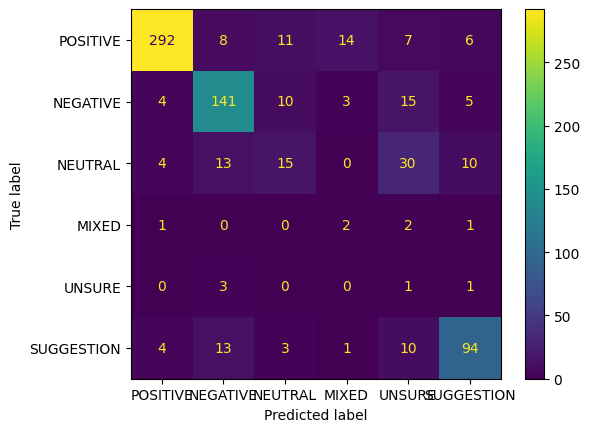

In [79]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(merged_df['abe_annotation'], merged_df['mengyuan_annotation'], labels=["POSITIVE", "NEGATIVE", "NEUTRAL", "MIXED", "UNSURE","SUGGESTION"])
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["POSITIVE", "NEGATIVE", "NEUTRAL", "MIXED", "UNSURE","SUGGESTION"])
cm_display.plot()

In [81]:
#Generate classification report
report = classification_report(merged_df['abe_annotation'], merged_df['mengyuan_annotation'], target_names=labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    POSITIVE       0.10      0.33      0.15         6
    NEGATIVE       0.79      0.79      0.79       178
     NEUTRAL       0.38      0.21      0.27        72
       MIXED       0.96      0.86      0.91       338
      UNSURE       0.80      0.75      0.78       125
  SUGGESTION       0.02      0.20      0.03         5

    accuracy                           0.75       724
   macro avg       0.51      0.52      0.49       724
weighted avg       0.82      0.75      0.78       724

